### MLP Model

Multilayer Perceptron Models for Time Series Forecasting

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation

In [137]:
apple_close_price = get_apple_close_price()

In [138]:
short_series = get_range(apple_close_price, '2003-01-01')

In [139]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 5 # days forecast
batch_size = 32 # for NN, batch size before updating weights
n_epochs = 100 # for NN, number of training epochs

We need to first train/test split, then transform and scale our data

In [140]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [141]:
train, test= train_test_split(apple_close_price,'2018-05-31')

In [142]:
boxcox_series, lmbda = boxcox(train.values)

In [143]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

# transformed_train = train.values
# transformed_test = test.values

In [144]:
from sklearn.preprocessing import MinMaxScaler

In [145]:
scaler = MinMaxScaler()

In [146]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [147]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)
y_train = y_train.reshape(-1, n_outputs)

In [148]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras.layers import LeakyReLU, BatchNormalization, Dropout
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

In [150]:
def build_MLP(look_back, n_features, n_outputs, optimizer='adam'):
    model = Sequential()

    model.add(Dense(64, 
                    activation='relu', 
                    input_shape=(look_back, n_features)))
    model.add(Flatten())
    model.add(Dense(n_outputs))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [151]:
model = build_MLP(look_back, n_features, n_outputs)

In [152]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 5, 64)             128       
_________________________________________________________________
flatten_12 (Flatten)         (None, 320)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 1605      
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
_________________________________________________________________


In [153]:
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, shuffle=False)

Epoch 1/100
9439/9439 [==============================] - 1s 123us/step - loss: 0.0019
Epoch 2/100
9439/9439 [==============================] - 1s 77us/step - loss: 6.5036e-04
Epoch 3/100
9439/9439 [==============================] - 1s 77us/step - loss: 2.9901e-04
Epoch 4/100
9439/9439 [==============================] - 1s 78us/step - loss: 2.0652e-04
Epoch 5/100
9439/9439 [==============================] - 1s 79us/step - loss: 2.0038e-04
Epoch 6/100
9439/9439 [==============================] - 1s 77us/step - loss: 2.2676e-04
Epoch 7/100
9439/9439 [==============================] - 1s 77us/step - loss: 2.6737e-04
Epoch 8/100
9439/9439 [==============================] - 1s 77us/step - loss: 3.0496e-04
Epoch 9/100
9439/9439 [==============================] - 1s 78us/step - loss: 3.1694e-04
Epoch 10/100
9439/9439 [==============================] - 1s 77us/step - loss: 2.9996e-04
Epoch 11/100
9439/9439 [==============================] - 1s 77us/step - loss: 2.7335e-04
Epoch 12/100
9439/9439

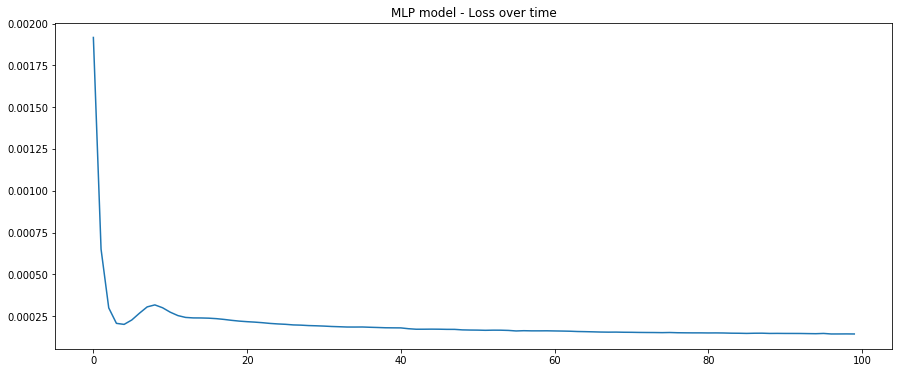

In [154]:
plot_series(history.history['loss'], title='MLP model - Loss over time')

In [155]:
model.save_weights('mlp-model_weights.h5')

In [156]:
size = 252 # approx. one year
predictions = NN_walk_forward_validation(model, 
                                         scaled_train, scaled_test[:252],
                                         size=size,
                                         look_back=look_back, 
                                         n_outputs=n_outputs)

In [157]:
from utils import plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [158]:
descaled_preds = scaler.inverse_transform(predictions.reshape(-1, 1))
descaled_test = scaler.inverse_transform(scaled_test.reshape(-1, 1))

descaled_preds = inv_boxcox(descaled_preds, lmbda)
descaled_test = inv_boxcox(descaled_test, lmbda)

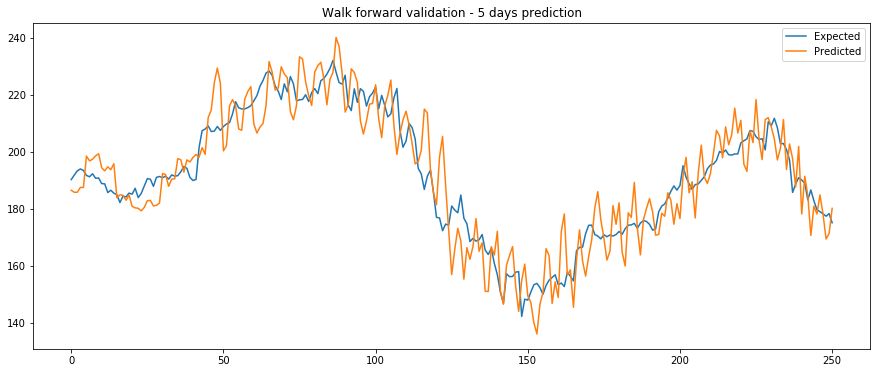

In [159]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size])
plt.plot(descaled_preds)
ax.set_title('Walk forward validation - 5 days prediction')
ax.legend(['Expected', 'Predicted'])

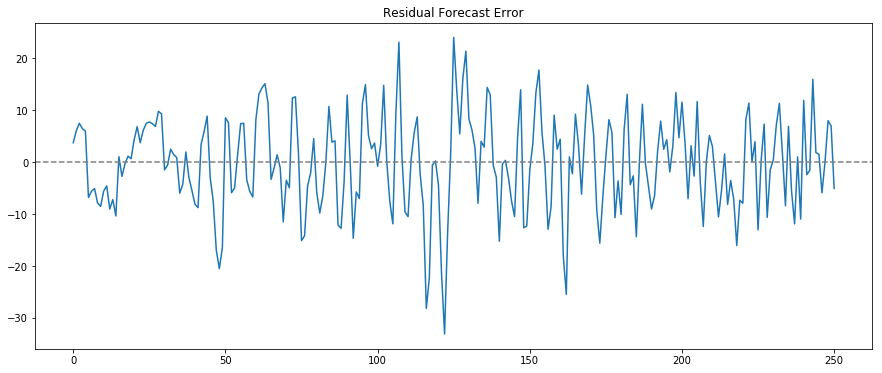

In [160]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size])

In [161]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size],
                          model_name='MLP', 
                          total_days=size, steps=n_outputs)

MLP[252 days, 5 days forecast]:

Forecast Bias: -0.221
MAE: 7.241
MSE: 83.444
RMSE: 9.135
MAPE: 3.845


In [ ]:
model.load_weights('mlp-model_weights.h5')